## 0. Import all the libraries

In [13]:
import numpy as np
import numpy.linalg as la
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import string
import tqdm
import numba
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import spacy

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/leonid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/leonid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/leonid/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 1. Print all the sentences

In [4]:
with open('input.txt') as f:
    lines = [line.strip() for line in f]

print(lines[:10])

['A person is on a baseball team.\tA person is playing basketball on a team.', 'Our current vehicles will be in museums when everyone has their own aircraft.\tThe car needs to some work', 'A woman supervisor is instructing the male workers.\tA woman is working as a nurse.', 'A bike is next to a couple women.\tA child next to a bike.', 'The group is eating while taking in a breathtaking view.\tA group of people take a look at an unusual tree.', 'The boy is raising his hand.\tThe man is raising his hand.', 'A man with a gray beard is being shaved in front of a lecture hall\tA man with a beard is sitting in the grass.', 'The sky has very little to no clouds.\tThis Lady might be ready for Rock Climbing, or just watching the Clouds, above.', 'The young boy jumps barefoot outside in the front yard.\tThe teen rode his bike around the people walking in the courtyard.', 'There are dogs in the forest.\tThe dogs are alone in the forest.', 'Some cyclists stop near a sign.\tTwo men stop to talk nea

## 2. Preprocessing : remove punctuation, stopwords and lemmatize

In [5]:
stopwords_en = stopwords.words('english')
translation_table = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer()

words = dict()
sentences = list()

for line in lines:
    s1, s2 = line.split('\t')

    v1 = []
    v2 = []

    for s, v in [(s1, v1), (s2, v2)]:
        for w in s.split():
            w = w.lower().translate(translation_table)
            if w in stopwords_en:
                continue
            w = lemmatizer.lemmatize(w)
            words.setdefault(w, len(words))
            v.append(words[w])

    sentences.append((v1, v2))

## 3. Make synonyms graph

In [6]:
synonym_graph = np.zeros((len(words), len(words)))

def set_of_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            syn_word = l.name()
            if syn_word in stopwords_en:
                continue
            syn_word = lemmatizer.lemmatize(syn_word)
            synonyms.append(syn_word)
    return set(synonyms)

for word, idx in words.items():
    for syn in set_of_synonyms(word):
        if syn not in words:
            continue
        syn_idx = words[syn]
        synonym_graph[idx][syn_idx] = 1
        synonym_graph[syn_idx][idx] = 1

In [7]:
print(set_of_synonyms(list(words.keys())[0]))
print(sum(synonym_graph[0]))


{'someone', 'mortal', 'individual', 'person', 'soul', 'somebody'}
3.0


## 4. Make sliding window graph

In [8]:
window_size = 3

window_graph = np.zeros((len(words), len(words)))

for ss in sentences:
    for s in ss:
        window = []
        for i in range(len(s)):
            window = window[-(window_size - 1):]
            v1 = s[i]
            for v2 in window:
                window_graph[v1][v2] += 1
                window_graph[v2][v1] += 1
            window.append(v1)

## 5. Combine synonym and window graphs
Complete distance matrix with shortest path lengths

In [9]:
distances = 1 / (synonym_graph + window_graph)
np.fill_diagonal(distances, 0)

def shortest(dist):
    N = dist.shape[0]
    
    @numba.jit
    def helper(dist, N, k):
        for i in range(N):
            for j in range(N):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])

    for k in tqdm.trange(N):
        helper(dist, N, k)

shortest(distances)

<ipython-input-9-b55119c89884>:1: RuntimeWarning: divide by zero encountered in true_divide
  distances = 1 / (synonym_graph + window_graph)
100%|██████████| 762/762 [00:00<00:00, 1429.08it/s]


## 6. MDS

In [10]:
@numba.jit
def mds(matD, k):
    N = matD.shape[0]
    matJ = np.eye(N) - np.ones((N, N)) / N
    matG = -0.5 * matJ @ (matD ** 2) @ matJ
    vecL, matP = la.eigh(matG)
    vecL[vecL < 0] = 0
    return matP[:,-k:], vecL[-k:]

def embed_graph(distances, k):
    p, l = mds(distances, k)
    result = p @ np.diag(np.sqrt(l))
    result -= np.mean(result, axis=0)
    return result

Порядок слов.

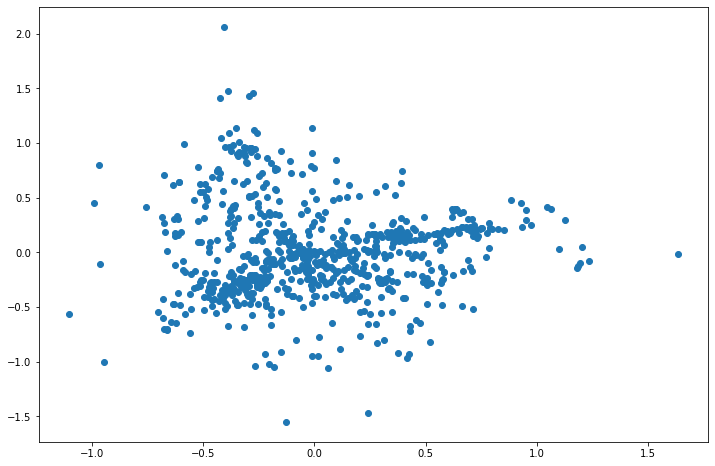

In [11]:
word_to_vec = embed_graph(distances, 10)

plt.figure(figsize=(12,8))
plt.scatter(*embed_graph(distances, 2).transpose())
plt.show()

In [16]:
nlp = spacy.load('en_core_web_lg')

for i, (s1, s2) in enumerate(sentences):
    v1 = np.mean(word_to_vec[s1,:], axis=0)
    v2 = np.mean(word_to_vec[s2,:], axis=0)
    d = dist.cosine(v1, v2)
    sent1 = nlp(' '.join([word for word in s1 if word not in stopwords_en]))
    sent2 = nlp(' '.join([word for word in s1 if word not in stopwords_en]))
    similarity = sent1.similarity(sent2)
    print(i, "{:1.8f} {:1.8f}".format(d, similarity), lines[i], sep='\t')
    if i > 30:
        break

[0, 1, 2]


TypeError: sequence item 0: expected str instance, int found